# Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) formulates a hierachical model over collections of discrete data sets, for instance *words*, *documents* and *topics*. Following the [original paper](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) by David Blei:

1) every word of a document derives from a finite mixture of topics,

2) every topic is derived from an possibly infinite set of topics,

3) every document is consists of by several topics.

A *word* is the most basic unit of the data set, represented by a categorial variable and belonging to a vocabulary of size $W$. A *document*  $\mathbf{D}$ is a sequence of $N$ words, i.e. a $N$-dimensional vector of categorical variables.
A *corpus* $\mathbf{C}$ is a collection of $D$ documents, i.e. a binary $(D \times N)-$dimensional matrix. The goal of LDA is to infer topic probabilities for single words for a set of topics of size $T$.

In this notebook we implement a Gibbs sampler for inferring the distribution over the parameters following Kevin Murphy's [book](https://mitpress.mit.edu/books/machine-learning-1) and the [original paper](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf).

LDA defines the following hierarchical Bayesian model for a corpus of documents:

\begin{align*}
\boldsymbol \pi_d & \sim \text{Dirichlet}_T(\alpha, \dots, \alpha) \\
\boldsymbol \phi_t & \sim \text{Dirichlet}_W(\gamma, \dots, \gamma) \\
z_{di} \mid \boldsymbol \pi_d & \sim \text{Categorical}(\boldsymbol \pi_d) \\
x_{di} \mid z_{di} = t & \sim \text{Categorical}(\boldsymbol \phi_t)
\end{align*}

The variables represent:
* $d$ indexes a document
* $T$ is the number of different topics
* $\boldsymbol \pi_d \in R_+^T$ are probabilities for each topic in document $d$
* $t$ indexes a topic
* $W$ is the number of different words in the vocabulary
* $\boldsymbol \phi_t \in R_+^W$ are probabilities for different words for topic $t$
* $i$ indexes the $i$th word in a document $d$
* $z_{di}$ is the latent topic of the $i$th word in document $d$
* $x_{di}$ is the $i$th word in document $d$

This inspires a very simple Gibbs sampler which we can use to infer the probabilities and the latent topics. Following Murphy's book, i.e. equations (27.30), (27.31) and (27.32):

1) Compute $P(z_{di} = t \mid \dots) \propto \exp \left( \log \pi_{dt} + \log \phi_{t, x_{di}} \right)$ and sample topics proportionally from $P(z_{di})$.

2) Compute $P(\boldsymbol \pi_d \mid \dots) = \text{Dirichlet}\left(\left\{ \alpha_t + \sum_i \mathbb{I}(z_{di} = t )\right\} \right)$

3) Compute $P(\boldsymbol \phi_t \mid \dots) = \text{Dirichlet}\left(\left\{ \gamma_w + \sum_d \sum_i \mathbb{I}(x_{di} = w, z_{di} = t) \right\} \right)$

where $w$ is a specific word in the vocabulary.

Let' implement this. First we load a bunch of libraries, we will use.

In [1]:
library(readr)
library(stringr)
library(tidyr)
library(tokenizers)
library(gutenbergr)
library(tidytext)
library(e1071)
suppressMessages(library(MCMCpack))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”

We will use some of Aeschylus' works from the Gutenberg corpus. He has four different plays/series:

In [2]:
gutenberg_works(str_detect(author, "Aeschylus")) 

gutenberg_id,title,author,gutenberg_author_id,language,gutenberg_bookshelf,rights,has_text
8604,"The House of Atreus; Being the Agamemnon, the Libation bearers, and the Furies",Aeschylus,2825,en,Harvard Classics/Classical Antiquity,Public domain in the USA.,TRUE
8714,Four Plays of Aeschylus,Aeschylus,2825,en,Classical Antiquity,Public domain in the USA.,TRUE
14417,The Agamemnon of Aeschylus Translated into English Rhyming Verse with Explanatory Notes,Aeschylus,2825,en,Classical Antiquity/Harvard Classics,Public domain in the USA.,TRUE
27458,Aeschylus' Prometheus Bound and the Seven Against Thebes,Aeschylus,2825,en,NA,Public domain in the USA.,TRUE


We can easily download the text using `gutenberg_download`:

In [3]:
books <- gutenberg_works(str_detect(author, "Aeschylus")) %>% 
    pull(gutenberg_id) %>%
    gutenberg_download()

Determining mirror for Project Gutenberg from http://www.gutenberg.org/robot/harvest
Using mirror http://aleph.gutenberg.org


To make LDA work, we unnest the single words in each document, and take the most five frequent ones per document.

In [4]:
highest_wordcount <- books %>%
    unnest_tokens(word, text) %>%
    group_by(gutenberg_id, word) %>%
    summarize(count = n()) %>%
    filter(str_length(word) > 5) %>%    
    group_by(gutenberg_id) %>%
    arrange(desc(count)) %>%
    top_n(5) %>%
    arrange(gutenberg_id, desc(count)) %>%
    select(-count)

Selecting by count


Then we factorize the words giving them numeric labels, since we consider a word to be a sample from a categorical distribution.

In [5]:
highest_wordcount <- highest_wordcount %>%
    mutate(idx = factor(word, 
            levels = sort(unique(word)), 
            labels = as.character(seq(unique(word)))))
highest_wordcount

gutenberg_id,word,idx
8604,chorus,2
8604,orestes,5
8604,clytemnestra,3
8604,apollo,1
8604,electra,4
8714,chorus,2
8714,prometheus,4
8714,xerxes,5
8714,against,1
8714,eteocles,3


To be able to work with the data, we cast the numeric words as a $N \times W$ matrix. An element $ij$ in the matrix represents a specific word $w$ in document $i$ at position $j$.

In [6]:
X <- matrix(as.integer(highest_wordcount$idx), byrow = T, ncol = 5)
X

2,5,3,1,4
2,4,5,1,3
3,4,2,1,5
1,5,3,2,4


Set number of words and documents from the matrix. Then set the number of topics and hyperparameters.

In [7]:
n_w <- ncol(X)
n_d <- nrow(X)
n_t <- 3
alpha <- 1
gamma <- 1

Randomly initialize topics  `Z` for every word, topic probabilities for every document `pis` and word probabilities `phis` for every document.

In [8]:
(Z = matrix(rdiscrete(n_d * n_w, rep(1, n_t) / n_t), n_d, n_w))

1,1,3,2,1
1,3,3,2,2
3,3,3,2,1
3,3,1,1,3


In [9]:
(pis <- rdirichlet(n_d, gamma * rep(1, n_t)))

0.9302511,0.05701714,0.01273178
0.3224238,0.18612333,0.49145283
0.2357121,0.68304726,0.08124062
0.4506294,0.22428531,0.32508530


In [10]:
(phis <- rdirichlet(n_t, gamma * rep(1, n_w)))

0.35637527,0.1359131,0.15128208,0.00767479,0.348754780
0.12236014,0.6312567,0.08802502,0.15100464,0.007353506
0.01543302,0.1861434,0.44063488,0.30611614,0.051672516


Then we use the Gibbs sampler from above to infer the posteriors. I maximize the topic assignments here, such that we get the MAP for them.

In [11]:
set.seed(23)
for (iter in seq(100)) {
    # sample from full conditional P(Z_di | ...) according to Murphy eqn. (27.30)
    # iterate over all documents and words in documents z_il
    for (d in seq(n_d)) {
        for (i in seq(n_w)) {
            p <- exp(log(pis[d, ]) + log(phis[, X[d, i]]))
            p <- p / sum(p)
            Z[d, i] <- which.max(rdirichlet(1, p))
        }
    }
    # sample from full conditional P(pi_i | ...) according to Murphy eqn. (27.31)
    # iterate over all document probability vectors pi_d
    for (d in seq(n_d)) {
        # compute the inner sum in (27.31)
        n <- sapply(seq(n_t), function(t) sum(Z[d, ] == t))
        pis[d, ] <- rdirichlet(1, alpha + n)
    }
               
    # sample from full conditional P(phi_i | ...) according to Murphy eqn. (27.32)
    # iterate over all topics
    for (t in seq(n_t)) {
        n <- rep(0, n_w)
        # iterate over all words w
        for (w in seq(n_w)) {
            # compute inner sums in (27.32)
            for (d in seq(n_d)) {
                # we could vectorize this loop but that only confuses here I think
                for (i in seq(n_w)) {
                    n[w] <- n[w] + sum(X[d, i] == w & Z[d, i] == t)
                }
            }
        }
        phis[t, ] <- rdirichlet(1, gamma + n)
    }
}

Let's look at the posterior of topic probabilities per document:

In [12]:
pis

0.2818161,0.32844979,0.3897341
0.0440834,0.72585345,0.2300631
0.6615493,0.08696728,0.2514834
0.3553352,0.01899738,0.6256674


And the word probabilities per topic:

In [13]:
phis

0.45056337,0.04313888,0.02708967,0.2670922,0.21211588
0.09159867,0.05220157,0.15878013,0.2966305,0.40078912
0.21627915,0.34577463,0.31874386,0.1159974,0.00320497


Finally, what we are actually interested in, the most probable topics for each word. We add the topics to the single words and plot them.

In [14]:
highest_wordcount$topic <- as.numeric(t(Z))

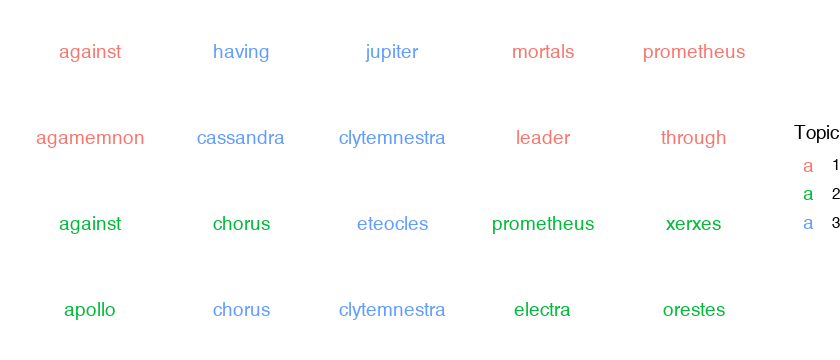

In [15]:
options(repr.plot.height=3)
ggplot(highest_wordcount) +
    geom_text(aes(as.factor(idx), as.factor(gutenberg_id), label=word, col=as.factor(topic))) +
    theme_void() +
    scale_x_discrete("Word") +
    scale_y_discrete("Document") +
    scale_color_discrete("Topic")